# BCI Move Validation

This notebook runs the EEG Quality Index to compare the following datasets:
- Clean data: Taken from [Babayan et al. 2019](http://fcon_1000.projects.nitrc.org/indi/retro/MPI_LEMON.html)
- Baseline data: 220607 PT Emotiv Flex
- P300 data: 220531 PT P300 DSI24

**Notes**
- You need to download the data from the paper and CPSP drives or feed your own data for the notebook to work.

## Import libraries

In [1]:
# Open plots in separate interactive window
%matplotlib widget

# Import libraries
import os
import mne
import sys
import pyxdf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.fft as fft
import scipy.stats as stats
import matplotlib.pyplot as plt
sys.path.append("..") # Adds higher directory to python modules path.
from Functions import eeg_quality_index

## Create MNE objects from datasets

In [2]:
# Get data directory
current_directory = os.getcwd()
os.chdir("..")
data_folder = os.getcwd() + '\\Data\\'
os.chdir(current_directory)

# Import clean data
clean_file = data_folder+'sub-032305.vhdr'
clean = mne.io.read_raw_brainvision(clean_file, verbose=False, preload=True)

# Create MNE object for XDF data
stream = 1  # Select proper stream from XDF file
streams, header = pyxdf.load_xdf(data_folder+'\\220531 P300 DSI24\\sub-P001_ses-S001_task-PT_P300_run-001_eeg.xdf')
sfreq = float(streams[stream]['info']['nominal_srate'][0])                  # Sampling frequency [Hz]
n_chans = len(streams[stream]['info']['desc'][0]['channels'][0]['channel']) # Number of channels [n]
chans = [streams[stream]['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(n_chans)]   # Channel names
info = mne.create_info(chans, sfreq, ch_types='eeg')
data = streams[stream]['time_series'].T # EEG data [uV]
p300 = mne.io.RawArray(data*1e-9, info, verbose=False) # Create MNE object

# Import EDF data to MNE object
baseline = mne.io.read_raw_edf(data_folder+'\\220607 Baseline Emotiv Flex\\PT_06.07.22_RS_EPOCFLEX_99556_2022.06.07T17.27.25.06.00.edf',
                            verbose=False,
                            preload=True)

## Plot RAW data

Enable one of the corresponding commands to plot the selected raw dataset

In [3]:
# clean.plot(title='Clean dataset', verbose=False)
# test.plot(title='Test dataset')
# baseline.plot(title='Baseline dataset3', verbose=False)

## Clean data

Filter and epoch clean data to select a "clean" epoch for the EEG Quality Index processing. Event markers are:
- S200 - eyes open
- S210 - eyes closed

**Notes**
- Use the `base_corr` variable to enable or disable baseline correction for the epochs.
- Use the `time_epoch` variable to select the time [sec] to trim the epochs.


In [4]:
# Filter data
fc = [0.1, 15]  # Cutoff frequencies [Hz]
clean.filter(l_freq=fc[0], h_freq=fc[1])

# Get parameters from data
clean_srate = clean.info['sfreq']       # Sampling frequency [Hz]
clean_chans = clean.info['ch_names']    # Channel names [list[str]]

# Get events from RAW data and create events_id's
events = mne.events_from_annotations(clean, verbose=False)

# Epoch data
events_id = {'S200':200, 'S210':210}
base_corr = None            # Interval for baseline correction [sec]. None = no correction
time_epoch = [0,1]          # Times to crop epochs [sec]
events_repeated = 'merge'   # Merge repeated events in marker data

# - All events
clean_epoch = mne.Epochs(clean, events[0], events_id,
                        baseline=base_corr, tmin=time_epoch[0], tmax=time_epoch[1],
                        event_repeated=events_repeated, verbose=False)
# - Only eyes open data
clean_epoch_eo = mne.Epochs(clean, events[0], {'S200':200},
                            baseline=base_corr,tmin=time_epoch[0], tmax=time_epoch[1],
                            event_repeated='merge', verbose=False)
# - Only eyes closed data
clean_epoch_ec = mne.Epochs(clean, events[0], {'S210':210},
                            baseline=base_corr, tmin=time_epoch[0], tmax=time_epoch[1],
                            event_repeated='merge', verbose=False)

# Get numpy array epochs
clean_eo = clean_epoch_eo.get_data()
clean_ec = clean_epoch_ec.get_data()

## Baseline data

### RAW baseline data

Run the EEG Quality Index to compare the clean data vs the baseline data (raw)

In [5]:
# Get important parameters
baseline_channels = baseline.info['ch_names']   # Channel names
baseline_srate = baseline.info['sfreq']         # Sampling rate [Hz]
baseline_raw = baseline.get_data()

# Trim and select only EEG data
baseline_eeg_index = [6, 20]    # Channel indices, determined from baseline_channels
trim_times = [20, 100]          # Trim times [list] [sec]. Selected from RAW plot
baseline_raw = baseline_raw[range(baseline_eeg_index[0], baseline_eeg_index[1]),
                            int(trim_times[0]*baseline_srate):int(trim_times[1]*baseline_srate)]
                            
baseline_channels = baseline.info['ch_names'][baseline_eeg_index[0]:baseline_eeg_index[1]]   # Channel names

# Select subset of channels in clean data to match baseline data
# - Preallocate data
clean_chans_subset = [None] * len(baseline_channels)

# - Look for matching channels, store their index
for b,baseline_chan in enumerate(baseline_channels):
    for c,clean_chan in enumerate(clean_chans):
        if(clean_chan == baseline_chan):
            clean_chans_subset[b] = c

# Select epoch
epoch = [7] # Look at clean_epoch data (eyes open or eyes closed), select an epoch

# Score baseline vs clean
[clean_total, clean_percent, eqi_mean] = eeg_quality_index.scoring(clean_eeg=clean_eo[epoch, clean_chans_subset,:], 
                                test_eeg=baseline_raw,
                                srate_clean=int(clean_srate),
                                srate_test=int(baseline_srate),
                                window=[int(clean_srate/2), int(baseline_srate/2)],
                                slide=[195, 10])

print('RAW data')
print(f'Percentage of clean windows per channel:\n{clean_total}')

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
RAW data
Percentage of clean windows per channel:
[77.99607073 76.8172888  74.2632613   0.          0.          0.
  0.          0.          0.          0.          0.         70.23575639
  0.         75.44204322]


c:\Users\danie\Documents\Projects\EEG_quality_index\Notebooks\..\Functions\eeg_quality_index.py:80: RuntimeWarning: divide by zero encountered in true_divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\EEG_quality_index\Notebooks\..\Functions\eeg_quality_index.py:80: RuntimeWarning: invalid value encountered in true_divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


### Filtered baseline dataset

Compute EEG Quality Index after filtering the baseline data. Filters are the same as with the clean dataset.

In [6]:
# Filter and trim data
baseline.filter(l_freq=fc[0], h_freq=fc[1])
baseline_filt = baseline.get_data()
baseline_filt = baseline_filt[range(baseline_eeg_index[0], baseline_eeg_index[1]),
                            int(trim_times[0]*baseline_srate):int(trim_times[1]*baseline_srate)]

# Score baseline vs clean
[filt_total, filt_percent, filtt_eqi_mean] = eeg_quality_index.scoring(clean_eeg=clean_eo[epoch, clean_chans_subset,:], 
                                test_eeg=baseline_filt,
                                srate_clean=int(clean_srate),
                                srate_test=int(baseline_srate),
                                window=[int(clean_srate/2), int(baseline_srate/2)],
                                slide=[10, 10])

print('Filtered data')
print(f'Percentage of clean windows per channel:\n{filt_total}')

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Filtered data
Percentage of clean windows per channel:
[73.28094303 71.21807466 70.03929273  0.          0.          0.
  0.          0.          0.          0.          0.         67.48526523
  0.          0.        ]


### Visualize - heatmap

Visualize the EEG quality Index with a heatmap to see improvements in filtering the data. 

**Notes**
- Higher values in the heat map = cleaner data

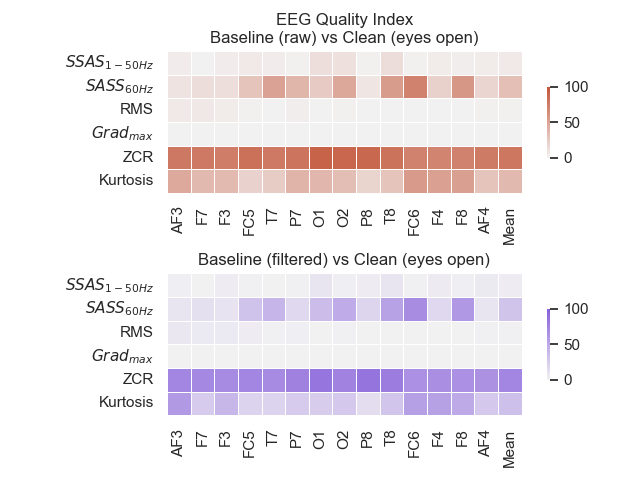

In [7]:
sns.set_theme(style="white")

row_names = ['$SSAS_{1-50 Hz}$', '$SASS_{60 Hz}$', 'RMS', '$Grad_{max}$', 'ZCR', 'Kurtosis']
column_names = baseline_channels + ['Mean']

# Generate a large random dataset
raw_percent_df = pd.DataFrame(data=np.concatenate((clean_percent, np.mean(clean_percent,1,keepdims=True)), axis=1), 
                            columns=column_names, index=row_names)
filt_percent_df = pd.DataFrame(data=np.concatenate((filt_percent, np.mean(filt_percent,1,keepdims=True)), axis=1), 
                            columns=column_names, index=row_names)


# Set up the matplotlib figure
f, ax = plt.subplots(2,1)

# Generate a custom diverging colormap
cmap1 = sns.diverging_palette(230, 20, as_cmap=True)
cmap2 = sns.diverging_palette(150, 275, as_cmap=True)

# Draw the heatmap
sns.heatmap(raw_percent_df, cmap=cmap1, vmax=100, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[0])
ax[0].set_title('EEG Quality Index\nBaseline (raw) vs Clean (eyes open)')

sns.heatmap(filt_percent_df, cmap=cmap2, vmax=100, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[1])
ax[1].set_title('Baseline (filtered) vs Clean (eyes open)')

plt.tight_layout()

## P300 data

Missing implementation to do similar analysis with epoched P300 data